In [1]:
# imports:  
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
torch.manual_seed(0);

In [5]:
x_train = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/x_train.pt').view(-1,1).requires_grad_(True)
x_test = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/x_test.pt').view(-1,1).requires_grad_(True)

print(x_train.size())

# y_test_R_1_5 = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=1.5.pt')
# y_test_R_4 = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=4.pt')
# y_test_R_6 = torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=6.pt')

# #Select R
# R = 1.5
# y_test = y_test_R_1_5

test_data = { 1.5:torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=1.5.pt'),
             4:torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=4.pt'),
             6:torch.load('/Users/lsierralopez/0. Machine Learning for Materials Design/PINNs Project/data/y_test_R=6.pt')}

R_values = [1.5, 4, 6]


torch.Size([20, 1])


In [3]:
#Defin the Fully Connected Layers
class FCN(nn.Module):
    def __init__(self, input, output, hidden, V, L):
        super().__init__()
        activation = nn.GELU()
        self.V = V
        self.L = L
        
        self.fc1 = nn.Linear(input, hidden)
        self.hidden1 = activation
        self.fc2 = nn.Linear(hidden, hidden)
        self.hidden2 = activation
        self.fc3 = nn.Linear(hidden, hidden)
        self.hidden3 = activation
        self.fc4 = nn.Linear(hidden, output)

    def forward(self, t):
        #We define how data will flow through our network
        t_initial = self.hidden1(self.fc1(t))
        t_hidden = self.hidden2(self.fc2(t_initial))
        t_hidden = self.hidden3(self.fc3(t_hidden))
        t_output = self.fc4(t_hidden)
        t = t * (self.V / self.L + t * t_output)
        #t = t_output * t
        # t = t_output
        return t
        

def calculate_loss_total(pinn, x_train, x_boundary, R, L, C, V):

    # compute boundary loss
    y = pinn(x_boundary)# (1, 1)
    loss_IC1 = (torch.squeeze(y) - 0)**2
    dydx = torch.autograd.grad(y, x_boundary, torch.ones_like(y), create_graph=True)[0]# (1, 1)
    loss_IC2 = (torch.squeeze(dydx) - V/L)**2

    # compute physics loss
    y = pinn(x_train)# (30, 1)
    dydx = torch.autograd.grad(y, x_train, torch.ones_like(y), create_graph=True)[0]# (30, 1)
    d2ydx2 = torch.autograd.grad(dydx, x_train, torch.ones_like(dydx), create_graph=True)[0]# (30, 1)
    loss_ODE = torch.mean((d2ydx2 + R/L *dydx + 1/(L*C) * y)**2)

    return loss_ODE + loss_IC1 + loss_IC2

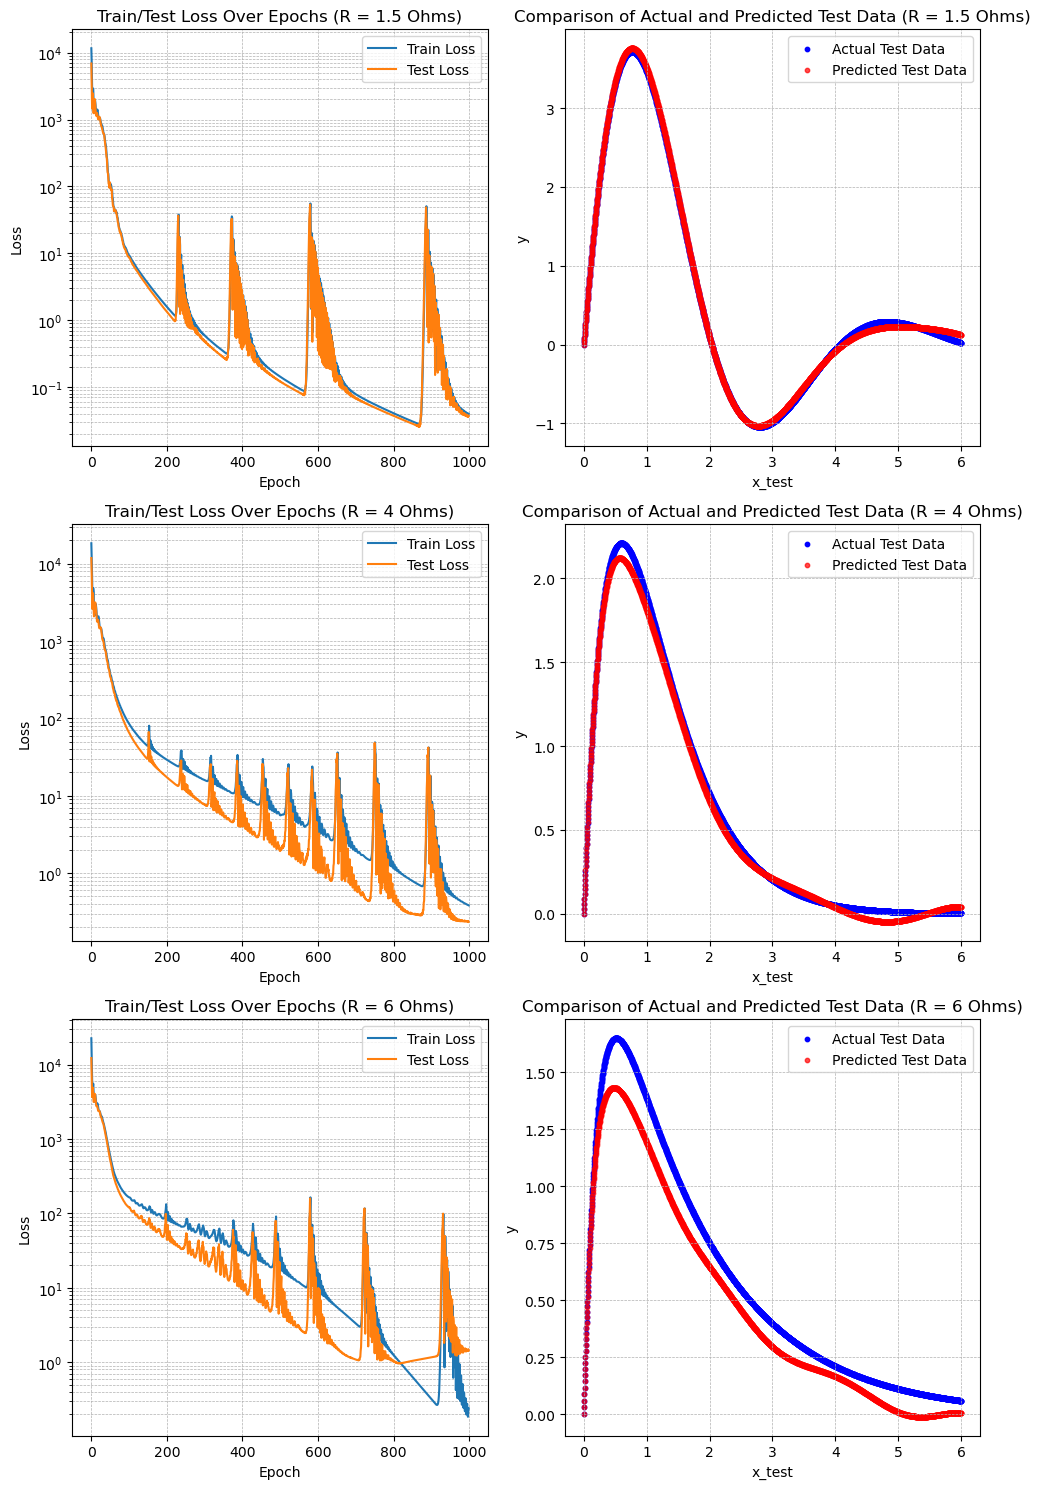

In [4]:
# Create a figure with 2 columns and 3 rows
fig, axs = plt.subplots(3, 2, figsize=(10, 15))  # Adjust figsize as needed

# Parameters
V = 12
L = 1.2
C = 0.3


for index, R in enumerate(R_values):
    y_test = test_data[R]

    #Define a Neurl Network to Train
    pinn = FCN(1,1,30, V, L)

    # Define an empty list to store loss history
    train_loss_history = []
    test_loss_history = []

    #Define Boundy point, for the boundary loss
    t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

    # Define Learning Rate
    lr = 0.01

    #Train the PINN
    optimizer = torch.optim.Adam(pinn.parameters(),lr=lr)

    #number of Epochs
    epochs = 1000
    for epoch in range(epochs):
        
        optimizer.zero_grad()
    
        # # using the following hyperparameters
        # lambda1, lambda2 = 1e-1, 1e-4
    
        #Calculate Loss
        train_loss = calculate_loss_total(pinn, x_train, t_boundary, R, L, C, V)
    
        #Store Loss
        train_loss_history.append(train_loss.detach().item())
        
        train_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        #Test Loss
        y_test_pred = pinn(x_test)
        test_loss = calculate_loss_total(pinn, x_test, t_boundary, R, L, C, V)
        test_loss_history.append(test_loss.detach().item())

    
    # Plot Train and Test Loss on the first column
    axs[index, 0].plot(train_loss_history, label='Train Loss')
    axs[index, 0].plot(test_loss_history, label='Test Loss')
    axs[index, 0].set_yscale('log')
    axs[index, 0].set_title(f'Train/Test Loss Over Epochs (R = {R} Ohms)')
    axs[index, 0].set_xlabel('Epoch')
    axs[index, 0].set_ylabel('Loss')
    axs[index, 0].legend()
    axs[index, 0].grid(True, which='both', linestyle='--', linewidth=0.5)


 # Plot Real vs Predicted on the second column
    y_test_pred = pinn(x_test)
    x_test_np = x_test.detach().numpy()
    y_test_np = y_test.detach().numpy()
    y_test_pred_np = y_test_pred.detach().numpy()
    
    axs[index, 1].scatter(x_test_np, y_test_np, color='blue', label='Actual Test Data', s=10)
    axs[index, 1].scatter(x_test_np, y_test_pred_np, color='red', alpha=0.7, label='Predicted Test Data', s=10)
    axs[index, 1].set_title(f'Comparison of Actual and Predicted Test Data (R = {R} Ohms)')
    axs[index, 1].set_xlabel('x_test')
    axs[index, 1].set_ylabel('y')
    axs[index, 1].legend()
    axs[index, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [ ]:
# y_test_pred = pinn(x_test)

# x_test_np = x_test.detach().numpy() if x_test.requires_grad else x_test.numpy()
# y_test_np = y_test.detach().numpy() if y_test.requires_grad else y_test.numpy()
# y_test_pred_np = y_test_pred.detach().numpy() if y_test_pred.requires_grad else y_test_pred.numpy()

# plt.figure(figsize=(8, 5))  # Set the figure size as desired

# # Plot actual test data with smaller dots
# plt.scatter(x_test_np, y_test_np, color='blue', label='Actual Test Data', s=10)  # s controls the dot size

# # Plot predicted test data with smaller dots
# plt.scatter(x_test_np, y_test_pred_np, color='red', alpha=0.7, label='Predicted Test Data', s=10)  # s controls the dot size

# # Adding a grid
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# # Adding legend to distinguish between actual and predicted values
# plt.legend()

# # Title and labels for the axes
# plt.title('Comparison of Actual and Predicted Test Data (R = 1.5 Ohms')
# plt.xlabel('x_test')
# plt.ylabel('y')

# # Show the plot
# plt.show()